In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import pytorch_lightning as L
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [3]:
df=pd.read_csv("daily_ibm_stock_data.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   100 non-null    object 
 1   timestamp    100 non-null    object 
 2   open         100 non-null    float64
 3   high         100 non-null    float64
 4   low          100 non-null    float64
 5   close        100 non-null    float64
 6   volume       100 non-null    float64
 7   date         100 non-null    int64  
 8   day_of_week  100 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 7.2+ KB


In [4]:


features=df[['open','high','low']].values
target=df['close'].values

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_feature=scaler.fit_transform(features)
scaled_target =scaler.fit_transform(target.reshape(-1,1)).flatten()

In [6]:

def create_sequences(features, target, sequence_length):
    X, y=[],[]
    for i in range(len(features) - sequence_length):
        X.append(scaled_feature[i:i+sequence_length])
        y.append(scaled_target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length=10
X, y = create_sequences(scaled_feature, scaled_target, sequence_length)

print(X,y)

[[[0.82423229 0.78951001 0.84117262]
  [0.81162624 0.7826087  0.7847495 ]
  [0.75253913 0.79618127 0.79029325]
  ...
  [0.82913132 0.7826087  0.77797379]
  [0.7623372  0.80239245 0.79127881]
  [0.90918867 0.88152749 0.86630431]]

 [[0.81162624 0.7826087  0.7847495 ]
  [0.75253913 0.79618127 0.79029325]
  [0.68443064 0.71911663 0.7210579 ]
  ...
  [0.7623372  0.80239245 0.79127881]
  [0.90918867 0.88152749 0.86630431]
  [1.         1.         1.        ]]

 [[0.75253913 0.79618127 0.79029325]
  [0.68443064 0.71911663 0.7210579 ]
  [0.69829131 0.72176213 0.69974523]
  ...
  [0.90918867 0.88152749 0.86630431]
  [1.         1.         1.        ]
  [0.86987693 0.91959972 0.92482174]]

 ...

 [[0.28462182 0.26270991 0.28322435]
  [0.29931892 0.27707154 0.2388743 ]
  [0.57474011 0.57648953 0.59231956]
  ...
  [0.55621938 0.52806533 0.57297801]
  [0.56840722 0.53134346 0.58357397]
  [0.55717529 0.54020014 0.59564581]]

 [[0.29931892 0.27707154 0.2388743 ]
  [0.57474011 0.57648953 0.59231956]


In [7]:
## convert to pytorch tensors
X=torch.tensor(X, dtype=torch.float32)
y=torch.tensor(y, dtype=torch.float32)

In [8]:
#train_size= len(scaled_feature)-10#train_size = int(0.8 * len(X))
train_size = len(X) -10
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

## create data loader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader= DataLoader(train_dataset, batch_size=32, shuffle=True)


In [9]:

class LightningLSTM(L.LightningModule):
    def __init__(self, input_size=3, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)  # Predict a single value (Close price)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)
        # Use the last time step's output
        out = self.linear(lstm_out[:, -1, :])
        return out

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

In [10]:
model=LightningLSTM()
for name,param in model.named_parameters():
    print(name, param.data)


lstm.weight_ih_l0 tensor([[ 1.1862e-01, -1.7448e-01, -4.8164e-02],
        [-1.6213e-01, -5.9064e-02, -6.8089e-02],
        [-8.7166e-02, -8.7611e-02, -1.0962e-01],
        [ 9.4606e-02, -3.9292e-02, -1.7028e-02],
        [ 1.3212e-01, -7.9568e-02,  1.4637e-01],
        [ 1.7945e-02,  5.7371e-02, -1.1438e-01],
        [-1.3676e-02, -1.3220e-01, -1.2343e-01],
        [ 1.6097e-01, -2.6943e-02, -4.8847e-02],
        [-5.9271e-02,  6.2331e-02, -4.0748e-02],
        [ 9.5888e-02,  1.6439e-01, -8.7235e-02],
        [ 5.8393e-03,  1.0930e-01, -3.4516e-02],
        [ 7.6905e-02,  1.6704e-01,  1.1815e-01],
        [ 6.2838e-02,  9.4920e-03, -1.5264e-01],
        [-1.4486e-01, -1.6082e-01, -5.2608e-02],
        [ 9.9152e-02, -9.1146e-03, -1.2822e-02],
        [-1.4906e-01,  1.5472e-01,  2.3127e-02],
        [-3.9056e-03, -7.8237e-02,  6.5576e-02],
        [ 1.7427e-01, -3.1395e-02, -1.7524e-01],
        [-1.5631e-01, -2.5670e-02, -1.6474e-01],
        [ 2.7677e-02, -1.4777e-01,  7.3328e-02],
  

In [11]:
model = LightningLSTM()
trainer = L.Trainer(max_epochs=50)
trainer.fit(model, train_dataloaders=train_dataloader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/martix/Coding/env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium'

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [12]:

for name, param in model.named_parameters():
    print(name, param.data)

lstm.weight_ih_l0 tensor([[ 0.2220,  0.1736, -0.0988],
        [-0.1672, -0.0951, -0.0271],
        [-0.1308,  0.0507, -0.0131],
        [-0.0645,  0.1045, -0.0500],
        [-0.0407,  0.1442,  0.1242],
        [ 0.0690,  0.2279, -0.0456],
        [-0.0266,  0.1172,  0.1671],
        [-0.0225, -0.0416,  0.0706],
        [-0.0876,  0.1470,  0.0235],
        [-0.1109,  0.0849, -0.0105],
        [-0.0082,  0.0296, -0.1452],
        [-0.0683, -0.0571,  0.0690],
        [ 0.2125,  0.1518,  0.1164],
        [ 0.0398, -0.0279,  0.1413],
        [-0.1100,  0.0221,  0.1949],
        [ 0.1846,  0.1151,  0.2115],
        [ 0.1526,  0.1690, -0.0009],
        [-0.1011,  0.2115,  0.1278],
        [-0.0946,  0.1844,  0.0334],
        [-0.0356,  0.0680,  0.0455],
        [ 0.0305, -0.0887, -0.0691],
        [-0.0742,  0.0883, -0.0871],
        [ 0.0292,  0.0526,  0.2070],
        [-0.1752, -0.1457,  0.0184],
        [-0.1080, -0.1529,  0.0143],
        [ 0.0515, -0.0734, -0.0396],
        [-0.0489, -0

In [14]:
def predict_future(model, initial_sequence, num_days, scaler):
    predictions = []
    current_sequence = initial_sequence.copy()
    for _ in range(num_days):
        input_tensor = torch.tensor(current_sequence[-sequence_length:], dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            pred = model(input_tensor).item()
        predictions.append(pred)
        # Update the sequence with the new prediction
        new_row = np.append(current_sequence[-1][1:], pred)
        current_sequence = np.vstack([current_sequence, new_row])
    # Inverse transform the predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions).flatten()
    return predictions

# Example: Predict the next 100 days
initial_sequence = scaled_feature[-99:]  # Last 99 days
future_predictions = predict_future(model, initial_sequence, 1, scaler)


In [15]:
print(future_predictions)

[290.30213853]


In [13]:
## tain for good predictions
model = LightningLSTM()
trainer = L.Trainer(max_epochs=500,log_every_n_steps=2)
trainer.fit(model, train_dataloaders=train_dataloader)

for names, param in model.named_parameters():
    print(names, param.data)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params | Mode  | FLOPs
--------------------------------------------------
0 | lstm   | LSTM   | 4.7 K  | train | 0    
1 | linear | Linear | 33     | train | 0    
--------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


lstm.weight_ih_l0 tensor([[-1.4454e-01,  1.5880e-01, -4.2790e-02],
        [ 1.7443e-01,  6.7793e-02,  9.3346e-02],
        [ 2.8542e-01,  2.0276e-01,  7.0142e-02],
        [-1.9920e-01, -4.3088e-02,  1.3668e-01],
        [-6.8983e-02, -4.1685e-02,  1.7343e-01],
        [-1.1620e-01,  7.7267e-02, -9.1272e-02],
        [ 5.8699e-02,  5.9029e-02, -1.1802e-01],
        [ 4.7467e-02,  5.7439e-03,  2.1783e-01],
        [ 2.7964e-01,  2.0149e-02,  2.3912e-01],
        [ 6.8903e-02,  1.7157e-01,  2.4235e-01],
        [ 7.3514e-02,  4.9526e-02, -8.5455e-02],
        [ 1.7794e-01, -4.9955e-02,  1.9380e-01],
        [ 1.0069e-01, -5.9279e-02,  1.4523e-01],
        [ 1.9170e-01, -7.5441e-02, -3.0009e-03],
        [ 1.9386e-02,  1.3370e-01,  1.3023e-01],
        [ 2.4608e-01,  2.2901e-01,  2.1936e-01],
        [ 1.3471e-01,  8.7104e-02,  1.7137e-01],
        [-4.0158e-01, -6.7933e-02, -1.2348e-01],
        [-6.4032e-02,  8.2012e-02, -5.5943e-02],
        [ 2.0116e-01,  2.0842e-01,  2.4803e-01],
  

In [16]:
print(future_predictions)

[290.30213853]


In [17]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val).squeeze().numpy()

# Inverse transform the scaled predictions and actuals
y_val_pred_actual = scaler.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
y_val_actual = scaler.inverse_transform(y_val.numpy().reshape(-1, 1)).flatten()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_val_actual, y_val_pred_actual)
mse = mean_squared_error(y_val_actual, y_val_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_actual, y_val_pred_actual)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 1.8688
MSE: 5.0117
RMSE: 2.2387
R² Score: 0.2426


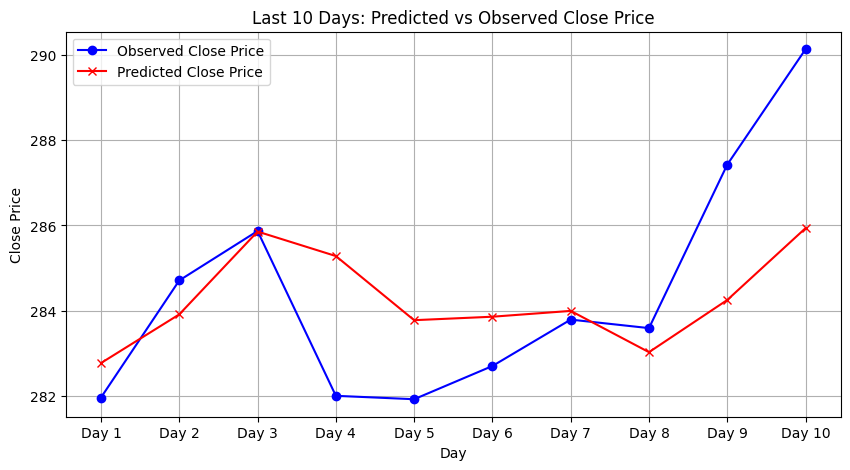

In [59]:
import matplotlib.pyplot as plt

# Plot the last 10 days: predicted vs observed
plt.figure(figsize=(10, 5))
plt.plot(y_val_actual, label='Observed Close Price', color='blue', marker='o')
plt.plot(y_val_pred_actual, label='Predicted Close Price', color='red', marker='x')
plt.title('Last 10 Days: Predicted vs Observed Close Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.xticks(range(len(y_val_actual)), [f'Day {i+1}' for i in range(len(y_val_actual))])
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# save the model
torch.save(model.state_dict(), "lstm_stock_model.pth")

import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']